In [1]:
#Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [9]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

# Reflect Tables into SQLAlchemy ORM 

In [4]:
#Create engine, this controls the connection to the database
engine = create_engine('sqlite:///./Resources/hawaii.sqlite')

In [10]:
#I use inspector so I can know the tables names, and later have a general view of the data
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [15]:
pd.DataFrame(inspector.get_columns('measurement'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0


In [12]:
pd.DataFrame(inspector.get_columns('station'))

,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [6]:
#Base, reflect the tables into classes
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [7]:
#save the references to the classes
ME = Base.classes.measurement

ST = Base.classes.station

In [8]:
#Session
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
#Most recent date
session.query(ME.date).order_by(ME.date.desc()).first()

('2017-08-23',)

In [19]:
#view the columns
me_columns = ME.__table__.columns
pd.DataFrame(session.query(*me_columns).limit(5))

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [29]:
#query that retrieves the dtaa and precipitation scores
me_df = pd.DataFrame(session.query(ME.date, ME.prcp).filter(ME.date >= '2016-08-23').all())

#set the columns names
me_df = me_df.rename(columns = {'date':'Date','prcp':'Inches'})
me_df

#sort the dataframe by date 

#print(type(me_df.Date[0]))
#the column date is a string, so I have to convert it to 'date'
me_df['Date'] = pd.to_datetime(me_df['Date'])

me_df = me_df.sort_values(by='Date')
me_df


,Date,Inches
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


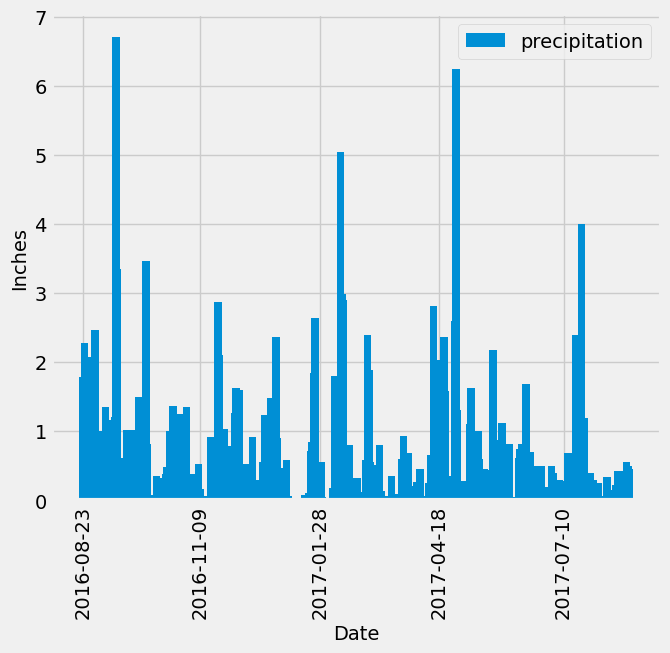

In [46]:
#Plot with matplotlib

plt.figure(figsize=(7,6))
plt.bar(me_df['Date'],me_df['Inches'], label ='precipitation', width = 5)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(['2016-08-23','2016-11-09','2017-01-28','2017-04-18','2017-07-10'])
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [47]:
#summary statistics
me_df['Inches'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Inches, dtype: float64

# Exploratory Station Analysis

In [52]:
#total number of stations
session.query(func.count(ST.station)).all()

[(9,)]

In [56]:
#import desc, so I can order the counts in descending 
from sqlalchemy import desc

In [58]:
# List the stations and their counts in descending order. I used group_by
session.query(ME.station, func.count(ME.station)).group_by(ME.station).order_by(desc(func.count(ME.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(ME.tobs),func.max(ME.tobs),func.avg(ME.tobs)).filter(ME.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

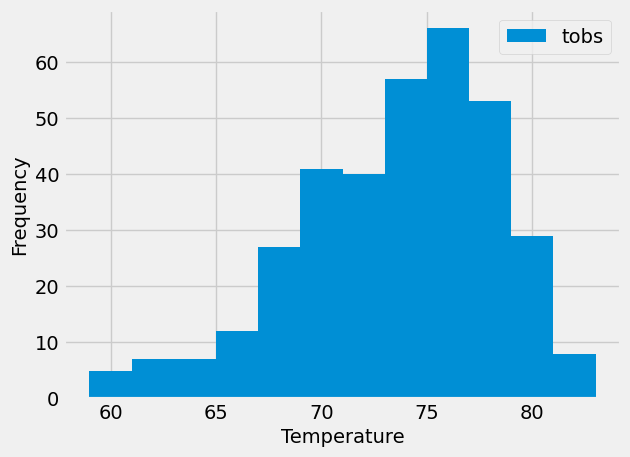

In [81]:
# Query the last 12 months of temperature observation data for this station and plot the results as a hist
results=session.query(ME.tobs).filter(ME.date >= '2016-08-23').filter(ME.station == 'USC00519281').all()

#Dataframe
tem_df = pd.DataFrame(results, columns=['Temperature'])

#plot
tem_df['Temperature'].hist(bins=12, label='tobs')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()



# Close Session

In [82]:
session.close()